In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as hcluster

In [2]:
import pandas as pd
import csv

In [3]:
import gensim

In [4]:
import logging
import warnings
warnings.filterwarnings('ignore')

In [5]:
m = 'tayga_upos_skipgram_300_2_2019.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

## Подготовка данных

читаем слова

In [7]:
with open('test_word_pairs.txt', 'r', encoding='utf-8') as f:
    df = pd.read_csv(f, sep='\t', header=None, names=['bigram', 'count'])

In [8]:
df.head()

,bigram,count
0,искать_человек,472
1,искать_работа,308
2,искать_спасение,280
3,искать_место,269
4,искать_счастие,199


делаем векторы

In [9]:
vectors = []

for bigrm in df['bigram']:
    verb, noun = bigrm.split('_')
    verb += '_VERB'
    noun += '_NOUN'
    vector = np.array(model[verb] + model[noun])
    vectors.append(vector)

df['vector'] = vectors

In [10]:
df.head()

,bigram,count,vector
0,искать_человек,472,"[-0.6140183, -0.12880707, 0.3736262, -0.608444..."
1,искать_работа,308,"[-0.4632162, -0.42220408, 0.14827853, -0.24437..."
2,искать_спасение,280,"[-0.84798986, -0.2599262, 0.7884264, -0.386328..."
3,искать_место,269,"[-0.7369178, -0.1946078, 0.285776, -0.39939538..."
4,искать_счастие,199,"[-0.61250615, -0.21946394, 0.70468414, -0.0321..."


переводим это добро в array

In [11]:
X = np.array(vectors)

In [12]:
X

array([[-0.6140183 , -0.12880707,  0.3736262 , ..., -0.33099422,
         0.37438005,  0.06657751],
       [-0.4632162 , -0.42220408,  0.14827853, ...,  0.12969016,
         0.45703304,  0.34317207],
       [-0.84798986, -0.2599262 ,  0.7884264 , ..., -0.06999396,
         0.33309647,  0.08373726],
       ...,
       [-0.39638615, -0.29813352,  0.6446053 , ..., -0.01037827,
         0.6465349 , -0.19454035],
       [-0.639605  , -0.14231233,  0.83451164, ..., -0.22803667,
         0.4326222 , -0.13635787],
       [-0.30234823, -0.36738163,  0.21350497, ..., -0.0100813 ,
         0.64862406, -0.24034956]], dtype=float32)

In [13]:
print(X.shape)

(100, 300)


## Иерархическая кластеризация

изучаю, какое кол-во кластеров дадут разные **методы** и значения **t**

In [9]:
def try_method(data, method):
    Z = hcluster.linkage(X, metric='cosine', method=method)
    plt.figure()
    dn = hcluster.dendrogram(Z)
    plt.show()
    n = {}
    for t in np.arange(0, 1.51, 0.01):
        clusters = hcluster.fcluster(Z, t)
        l = len(set(clusters))
        n[l] = t
    t_intervals = []
    x = 0
    for i in n.values():
        t = '{:03.2f} - {:03.2f}'.format(x, i)
        t_intervals.append(t)
        x = i
    return pd.DataFrame({'значение t': t_intervals, 'кол-во кластеров': list(n.keys())})

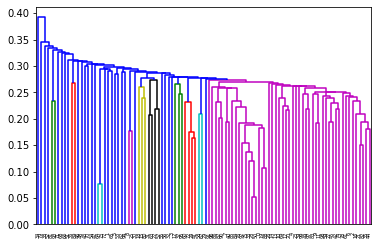

,значение t,кол-во кластеров
0,0.00 - 0.70,75
1,0.70 - 0.75,60
2,0.75 - 0.83,56
3,0.83 - 0.84,50
4,0.84 - 0.90,46
5,0.90 - 0.92,43
6,0.92 - 1.03,42
7,1.03 - 1.13,24
8,1.13 - 1.14,19
9,1.14 - 1.50,1


In [10]:
try_method(data = X, method = 'single')

Мне кажется что как-то не оч(

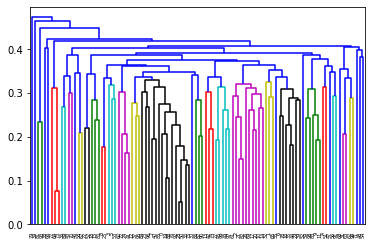

,значение t,кол-во кластеров
0,0.00 - 0.68,65
1,0.68 - 0.70,64
2,0.70 - 0.84,39
3,0.84 - 0.86,38
4,0.86 - 0.89,36
5,0.89 - 0.95,33
6,0.95 - 0.98,32
7,0.98 - 1.02,31
8,1.02 - 1.04,30
9,1.04 - 1.07,22


In [11]:
try_method(data = X, method = 'average')

Так гораздо лучше

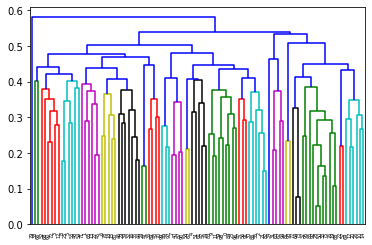

,значение t,кол-во кластеров
0,0.00 - 0.70,61
1,0.70 - 0.79,46
2,0.79 - 0.89,44
3,0.89 - 0.96,42
4,0.96 - 0.97,37
5,0.97 - 0.99,34
6,0.99 - 1.00,33
7,1.00 - 1.01,31
8,1.01 - 1.02,29
9,1.02 - 1.06,25


In [12]:
try_method(data = X, method = 'complete')

так тоже норм

**В итоге** я выбрала метод `'complete'` и `t = 1`, так как не заметила значимых разлчий в кластерах > 3 при изменеии параметра на `±0.05` (от 42 до 25 кластеров), но при большем кол-ве кластеров терялись некоторые вполне осмысленные группы, а при меньшем появлялись группы хуже интерпретируемые 

In [13]:
Z = hcluster.linkage(X, metric='cosine', method='complete')
h_clusters = hcluster.fcluster(Z, t = 1)
#h_clusters = hcluster.fclusterdata(X, 1, metric='cosine', method='complete')
print('Estimated number of clusters: %d' % len(set(h_clusters)))

Estimated number of clusters: 33


вот что получается

In [14]:
print(h_clusters)

[17  4 20  2 15  3  5 12  3 17 32 17  2  4 32  5  7 31  5 28 31 20 30 17
  8  3 32  4 27  6 19 21  7 27 23  7  9 26  1  6 12  8 16 10  7  4  6 18
  3 11 27 15  2  3  3 20 18 30 14 17  2 16 22 21 25  4  1 14  2 31 10  4
  2 25 16 27 28 25  5 33  5 24 20 17 17 29 19 13 28  9 13 18 27 24 22 26
 17 11 17 11]


записываю это в дф

In [15]:
df['hcluster_n'] = list(h_clusters)

In [ ]:
df.head()

считаю косинусную близость от центра каждого кластера с помощью `gensim.matutils.cossim()`

In [16]:
clusters = pd.DataFrame(columns = ['bigram', 'count', 'hcluster_n', 'hsim'])
for _, cluster in df.groupby('hcluster_n'):
    if len(cluster) > 2:
        
        #print(', '.join(sorted(list(cluster['bigram']))))
        
        cluster = cluster.loc[:, ['bigram', 'count', 'hcluster_n', 'vector']]
        mean = [(index, value) for index, value in enumerate(cluster['vector'].mean())]
        
        sims = []
        for v in cluster['vector']:
            v = [(index, value) for index, value in enumerate(v)]
            sims.append(gensim.matutils.cossim(v, mean))
        cluster['hsim'] = sims
        clusters = clusters.append(cluster.loc[:, ['bigram', 'count', 'hcluster_n', 'hsim']], ignore_index=True)
        
res = clusters.sort_values(['hcluster_n', 'hsim', 'bigram'], ascending=[True, False, True])
res.head()

,bigram,count,hcluster_n,hsim
3,искать_город,38,2,0.871077
5,искать_дом,35,2,0.870144
0,искать_место,269,2,0.861382
1,искать_время,157,2,0.852333
4,искать_земля,36,2,0.838021


распечатываю для каждого кластера топ-3 близких слова

In [17]:
hc_results = []
for _, cluster in res.groupby('hcluster_n'):
    s = 'кластер {:2.0f}: '.format(cluster['hcluster_n'].median()) + ', '.join(list(cluster['bigram'][:3]))
    hc_results.append(s)
    print(s)

кластер  2: искать_город, искать_дом, искать_место
кластер  3: искать_путь, искать_выход, искать_дорога
кластер  4: искать_встреча, искать_знакомство, искать_работа
кластер  5: искать_возможность, искать_способ, искать_необходимость
кластер  6: искать_смысл, искать_слово, искать_мысль
кластер  7: искать_объяснение, искать_оправдание, искать_ответ
кластер 11: искать_примирение, искать_компромисс, искать_сближение
кластер 16: искать_любовь, искать_дружба, искать_сочувствие
кластер 17: искать_истина, искать_вера, искать_человек
кластер 18: искать_уединение, искать_забвение, искать_свобода
кластер 20: искать_утешение, искать_успокоение, искать_спасение
кластер 25: искать_полиция, искать_милиция, искать_служба
кластер 27: искать_муж, искать_жена, искать_отец
кластер 28: искать_девушка, искать_женщина, искать_невеста
кластер 31: искать_поддержка, искать_покровительство, искать_помощь
кластер 32: искать_защита, искать_убежище, искать_опора


## Алгоритм К-средних (KMeans)

In [18]:
from sklearn.cluster import KMeans

я выбрала параметр `n_clusters = 33`, потому что так

1) кол-во кластеров сопоставимо с предыдущим методом

2) получаются осмысленные вещи (более-менее без странностей)

In [19]:
kmeans = KMeans(n_clusters = 33, n_init = 10).fit(X)
print(kmeans.labels_)

[ 7  3 22  3 23  3  2 10  0  4  6  4  3  7  6 29  2 12 29  1 12 22  3  7
  9  0 12 17 10  7  7 28  3 10 25  2 27  3 16  3 10  9 26 10  2 17 31 29
 11 20 10 21  7  7  7  3 30  3 14 24  7 26 13 28  5  3  7 14  7 12  7 32
  9  5 26 10  1 15  3  8 29 18 22  4  7 10 19 19  1 27 19 30 10 18 13  3
  7 20 24 17]


записываем в дф

In [20]:
df['kcluster_n'] = list(kmeans.labels_)

In [ ]:
df.head()

опять считаю косинусную близость от центра каждого кластера

In [22]:
clusters = pd.DataFrame(columns = ['bigram', 'count', 'kcluster_n'])
for _, cluster in df.groupby('kcluster_n'):
    if len(cluster) > 2:
        cluster = cluster.loc[:, ['bigram', 'count', 'kcluster_n', 'vector']]
        
        #print(', '.join(sorted(list(cluster['bigram']))))
        
        mean = [(index, value) for index, value in enumerate(cluster['vector'].mean())]
        
        sims = []
        for v in cluster['vector']:
            v = [(index, value) for index, value in enumerate(v)]
            sims.append(gensim.matutils.cossim(v, mean))
        cluster['sim'] = sims
        clusters = clusters.append(
            cluster.loc[:,['bigram', 'count', 'kcluster_n', 'sim']], ignore_index=True)
        
        
res = clusters.sort_values(['kcluster_n', 'sim', 'bigram'], ascending=[True, False, True])
res.head()

,bigram,count,kcluster_n,sim
2,искать_девушка,29,1,0.958775
0,искать_женщина,105,1,0.935099
1,искать_невеста,33,1,0.914495
5,искать_объяснение,58,2,0.935153
6,искать_оправдание,47,2,0.917603


опять распечатываю для каждого кластера топ-3 близких слова

In [23]:
km1_results = []
for _, cluster in res.groupby('kcluster_n'):
    s = 'кластер {:2.0f}: '.format(cluster['kcluster_n'].median()) + ', '.join(list(cluster['bigram'][:3]))
    km1_results.append(s)
    print(s)

кластер  1: искать_девушка, искать_женщина, искать_невеста
кластер  2: искать_объяснение, искать_оправдание, искать_ответ
кластер  3: искать_время, искать_работа, искать_смысл
кластер  4: искать_истина, искать_правда, искать_справедливость
кластер  7: искать_человек, искать_герой, искать_бог
кластер  9: искать_квартира, искать_комната, искать_дом
кластер 10: искать_муж, искать_отец, искать_жена
кластер 12: искать_поддержка, искать_покровительство, искать_помощь
кластер 17: искать_знакомство, искать_встреча, искать_сближение
кластер 19: искать_враг, искать_союзник, искать_убийца
кластер 22: искать_утешение, искать_успокоение, искать_спасение
кластер 26: искать_любовь, искать_дружба, искать_сочувствие
кластер 29: искать_возможность, искать_необходимость, искать_способ


## Дополнительно 1

Мне не очень понравилось, что KM с практически любым кол-вом кластеров выдает не всегда понятные вещи (например, при перезапуске на одних и тех же настройках *искать_убийца* может оказываться в абсолютно разных кластерах, иногда не очень понятно почему). Поэтому я на всякий случай еще попробовала KMeans из NLTK, результат меня так же не очень устроил.

In [57]:
from nltk.cluster import KMeansClusterer
import nltk

In [58]:
NUM_CLUSTERS=33
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=20)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print(assigned_clusters)

[18, 6, 5, 11, 5, 4, 20, 16, 28, 1, 11, 1, 25, 17, 11, 13, 10, 5, 0, 19, 5, 5, 15, 12, 30, 28, 8, 26, 19, 10, 17, 15, 3, 25, 14, 10, 2, 16, 31, 1, 19, 30, 5, 2, 10, 32, 7, 13, 10, 3, 19, 12, 14, 4, 20, 10, 23, 0, 9, 5, 18, 5, 22, 15, 24, 6, 8, 9, 11, 21, 2, 12, 30, 24, 32, 16, 19, 24, 29, 5, 13, 27, 5, 3, 18, 19, 25, 21, 19, 2, 21, 23, 25, 27, 22, 25, 12, 3, 5, 26]


In [61]:
df['kkcluster_n'] = assigned_clusters
df['compare'] = ['{}_{}_{}'.format(i, ii, iii) for i, ii, iii in zip(df['hcluster_n'], df['kcluster_n'], df['kkcluster_n'])]

clusters = pd.DataFrame(columns = ['bigram', 'count', 'kkcluster_n'])
for _, cluster in df.groupby('kkcluster_n'):
    if len(cluster) > 2:
        cluster = cluster.loc[:, ['bigram', 'count', 'kkcluster_n', 'vector']]
        
        #print(', '.join(sorted(list(cluster['bigram']))))
        
        mean = [(index, value) for index, value in enumerate(cluster['vector'].mean())]
        
        sims = []
        for v in cluster['vector']:
            v = [(index, value) for index, value in enumerate(v)]
            sims.append(gensim.matutils.cossim(v, mean))
        cluster['sim'] = sims
        clusters = clusters.append(
            cluster.loc[:,['bigram', 'count', 'kkcluster_n', 'sim']], ignore_index=True)
        
res = clusters.sort_values(['kkcluster_n', 'sim', 'bigram'], ascending=[True, False, True])

km2_results = []
for _, cluster in res.groupby('kkcluster_n'):
    s = 'кластер {:2.0f}: '.format(cluster['kkcluster_n'].median()) + ', '.join(list(cluster['bigram'][:3]))
    km2_results.append(s)
    print(s)

кластер  1: искать_истина, искать_правда, искать_смысл
кластер  2: искать_глаз, искать_лицо, искать_голова
кластер  3: искать_компромисс, искать_примирение, искать_справедливость
кластер  5: искать_утешение, искать_спасение, искать_успокоение
кластер 10: искать_объяснение, искать_оправдание, искать_ответ
кластер 11: искать_убежище, искать_место, искать_защита
кластер 12: искать_герой, искать_бог, искать_слава
кластер 13: искать_возможность, искать_необходимость, искать_свобода
кластер 15: искать_золото, искать_клад, искать_деньги
кластер 16: искать_сын, искать_другой, искать_день
кластер 18: искать_народ, искать_человек, искать_город
кластер 19: искать_муж, искать_жена, искать_девушка
кластер 21: искать_союзник, искать_враг, искать_покровительство
кластер 24: искать_полиция, искать_милиция, искать_служба
кластер 25: искать_отец, искать_мама, искать_время
кластер 30: искать_квартира, искать_комната, искать_дом


## Дополнительно 2

маленькая функция, чтобы удобно посмотреть на кластеры от разных слов глазами и сравнить как они кластеризовались 1, 2 и 3 методом

In [62]:
def get_cluster_of_noun(noun):
    bigram = 'искать_' + noun.lower()
    try:
        kk = df.loc[df['bigram'] == bigram]['kkcluster_n']
        k = df.loc[df['bigram'] == bigram]['kcluster_n']
        h = df.loc[df['bigram'] == bigram]['hcluster_n']
        combined = df[
            (df['hcluster_n'] == int(h)) | 
            (df['kcluster_n'] == int(k)) | 
            (df['kkcluster_n'] == int(kk))].sort_values('compare')
        return combined.filter(regex='^[hkb]', axis=1)
    except:
         print('такого слова нет, проверьте написание')

In [63]:
get_cluster_of_noun('москва')

,bigram,hcluster_n,kcluster_n,kkcluster_n
81,искать_россия,24,18,27
93,искать_москва,24,18,27


In [64]:
get_cluster_of_noun('бог')

,bigram,hcluster_n,kcluster_n,kkcluster_n
70,искать_голова,10,7,2
51,искать_слава,15,21,12
98,искать_христос,17,24,5
59,искать_вера,17,24,5
9,искать_истина,17,4,1
11,искать_правда,17,4,1
83,искать_справедливость,17,4,3
23,искать_бог,17,7,12
96,искать_герой,17,7,12
84,искать_народ,17,7,18


# Анализ

Попробуем проанализировать эти наборы по отдельности.

1. Иерархическая кластеризация (далее HC)

In [69]:
n = 0
for r in hc_results:
    n += 1
    print(r)
    
print('итого', n)

кластер  2: искать_город, искать_дом, искать_место
кластер  3: искать_путь, искать_выход, искать_дорога
кластер  4: искать_встреча, искать_знакомство, искать_работа
кластер  5: искать_возможность, искать_способ, искать_необходимость
кластер  6: искать_смысл, искать_слово, искать_мысль
кластер  7: искать_объяснение, искать_оправдание, искать_ответ
кластер 11: искать_примирение, искать_компромисс, искать_сближение
кластер 16: искать_любовь, искать_дружба, искать_сочувствие
кластер 17: искать_истина, искать_вера, искать_человек
кластер 18: искать_уединение, искать_забвение, искать_свобода
кластер 20: искать_утешение, искать_успокоение, искать_спасение
кластер 25: искать_полиция, искать_милиция, искать_служба
кластер 27: искать_муж, искать_жена, искать_отец
кластер 28: искать_девушка, искать_женщина, искать_невеста
кластер 31: искать_поддержка, искать_покровительство, искать_помощь
кластер 32: искать_защита, искать_убежище, искать_опора
итого 16


Полчаются следующие группы:
2. "место": тру поиск местонахождения
3. "путь": может быть метафорой
4. взаимодействие с другими людьми: жаждать, стремиться, надеяться
5. атрибуты действия: мысленный поиск
6. "значение": мысленный поиск
7. недостающая информация: стремление получить, может быть метафорой
11. "примирение": жаждать, стремиться, надеяться
16.  "чувства": жаждать, стремиться, надеяться
17. тут я не совсем уверена, похоже на что-то религиозно-филосовское
18. "ментальное самоощущение": жаждать, стремиться, надеяться
20. то же
25. "служба": прямой поиск человека определенной професии
27. "семья": прямой поиск челвека родственника
28. "невеста": перебор вариантов
31. "поддержка": нуждаться
32. то же, но чуть более материальное

Для дольшнейших групп я буду описывать только новые значения

2. Mетод К-средних из SciPy (далее KM1)

In [70]:
n = 0
for r in km1_results:
    n += 1
    print(r)
    
print('итого', n)

кластер  1: искать_девушка, искать_женщина, искать_невеста
кластер  2: искать_объяснение, искать_оправдание, искать_ответ
кластер  3: искать_время, искать_работа, искать_смысл
кластер  4: искать_истина, искать_правда, искать_справедливость
кластер  7: искать_человек, искать_герой, искать_бог
кластер  9: искать_квартира, искать_комната, искать_дом
кластер 10: искать_муж, искать_отец, искать_жена
кластер 12: искать_поддержка, искать_покровительство, искать_помощь
кластер 17: искать_знакомство, искать_встреча, искать_сближение
кластер 19: искать_враг, искать_союзник, искать_убийца
кластер 22: искать_утешение, искать_успокоение, искать_спасение
кластер 26: искать_любовь, искать_дружба, искать_сочувствие
кластер 29: искать_возможность, искать_необходимость, искать_способ
итого 13


Добавились:

3. не очень понятно, видимо просто то, чего всегда нехватает
9. "жилище": перебор вариантов
19. "розыск"

3. Mетод К-средних из NLTK (далее KM2) 

In [71]:
n = 0
for r in km2_results:
    n += 1
    print(r)
    
print('итого', n)

кластер  1: искать_истина, искать_правда, искать_смысл
кластер  2: искать_глаз, искать_лицо, искать_голова
кластер  3: искать_компромисс, искать_примирение, искать_справедливость
кластер  5: искать_утешение, искать_спасение, искать_успокоение
кластер 10: искать_объяснение, искать_оправдание, искать_ответ
кластер 11: искать_убежище, искать_место, искать_защита
кластер 12: искать_герой, искать_бог, искать_слава
кластер 13: искать_возможность, искать_необходимость, искать_свобода
кластер 15: искать_золото, искать_клад, искать_деньги
кластер 16: искать_сын, искать_другой, искать_день
кластер 18: искать_народ, искать_человек, искать_город
кластер 19: искать_муж, искать_жена, искать_девушка
кластер 21: искать_союзник, искать_враг, искать_покровительство
кластер 24: искать_полиция, искать_милиция, искать_служба
кластер 25: искать_отец, искать_мама, искать_время
кластер 30: искать_квартира, искать_комната, искать_дом
итого 16


В это раз появились значения:

2. части тела как метофара к человеку (*искать ее лицо в толпе*)
15. "капитал": стремиться добыть
16. кажется произошла небольшая свалка значений
18. "люди", не очень понимаю как так получилось (я сначала подумала, что на это повлияло окно при обучении модели, но оно всего 2)

Теперь проанализируем все результаты вместе.

Итого у нас получилось около 15 из 33 кластеров с > 3 элеметами, такой результат показался мне наиболее уместным (почти всегда удается избежать слишком большого и разносортного кластера-свалки с кучей значений, не особо понятно как связанных).


**Однородные ли, на ваш взгляд, получились группы?**

Мне кажется вполне (если смотреть на группы по 3 слова, об остальном ниже). По крайней мере, подавляющее большинство легко интерпретируются.

**Все ли значения глагола удалось «поймать» и проиллюстрировать?**

У глагола *искать* в русском языке целом не очень много прямых значений и еще меньше значений переносных. Если ориентироваться на данные из курса лекстипа (см. картинку), все имеющиеся значения тут представлены.

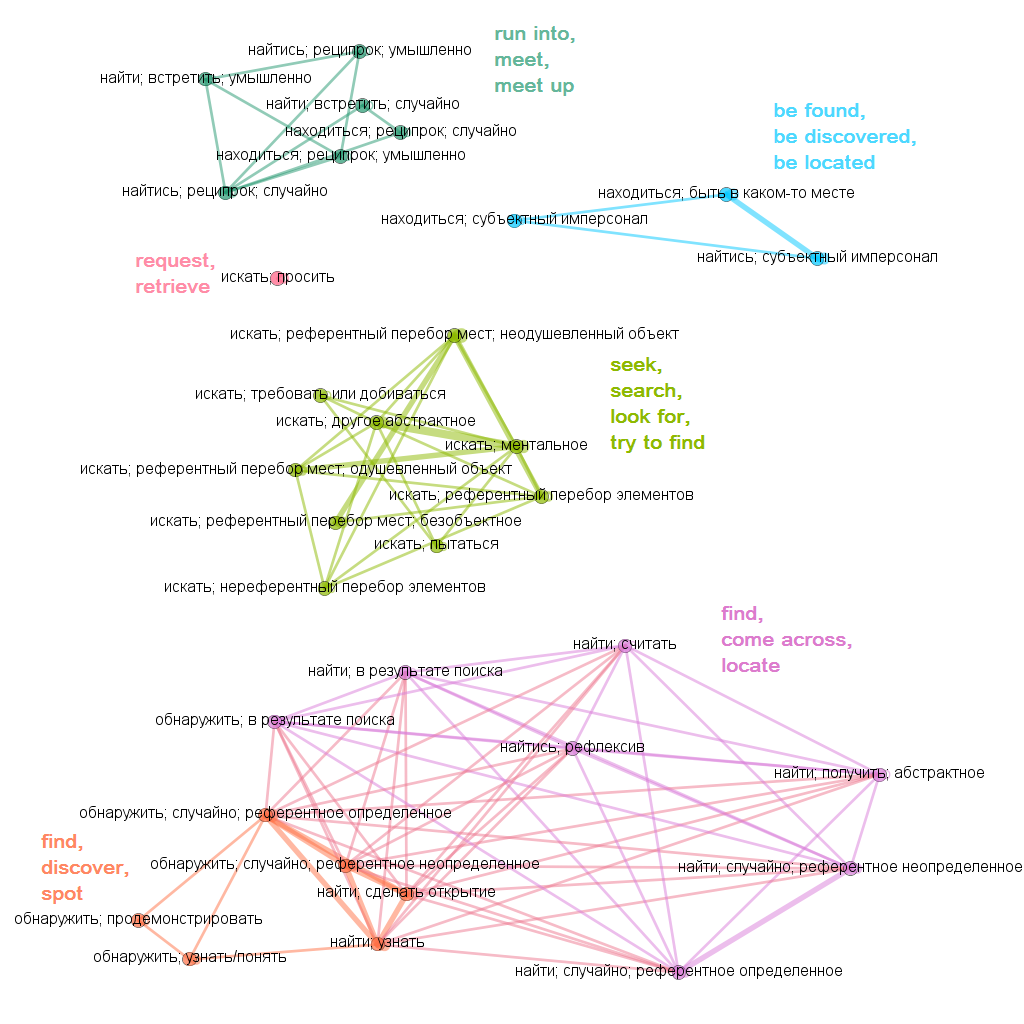

# Оставшиеся вопросы и гипотетические наблюдения

* *искать_руку* иногда кластеризуется с частями тела (*голова*), а иногда с *девушка, женщина*. Вероятно, это влияние выражения *просить руки*;
* то, какие понятия кластеризуются со словом *бог* досаточно хорошо передает библейские идеи;
* что есть общего между поиском жены и поиском убийцы;
* какие факторы влияют на распределение кластеризации *искать_смерть*;
* как поменяются результаты, если использовать модель, обученную с бóльшим окном;
* анализ того, что не попало в кластеры и почему - будет ли ответом размер выборки (100 слов);
* насколько любые из последующих мыслей имеют право на существование, если были порождены выборкой из 100 слов?

**В принципе, на этом можно остановиться и не читать дальше, потому что там много, но не очень важно.**

# Кратко, что написано дальше

Я руками сравнила, какие кластеры полностью совпадают в моделях (посчитала векторные суммы кластеров и посмотрела, где они одинаковые)

итого получилась следующая табличка:


|  ╲ | HC  | KM1 | KM2 |
|---:|:---:|:---:|:---:|
|HC  |  ╲  |18   |9    |
|KM1 |18   |  ╲  |15   |
|KM2 |9    |15   |  ╲  |

вне зависимости от конкретных результатов KM1 и KM2, соотношение всегда примерно такое.

Во всех трех моделях почти всегда есть следующие кластеры:    

1) искать_душа, искать_сердце 

2) искать_рыба, искать_добыча (cамое стабильное)

3) искать_россия, искать_москва (иногда разбавляется *искать_народ*, если он не попадает к *богу*)

Итого 6 слов.


Потом я решила попытаться визуализировать данные (исходные и получившиеся) и сравнить три модели глазами. Выводы из этого следующие: это было утомительно, но познавательно. Если долго смотреть, можно прийти к чувству, что некоторые выражения кластеризуются более стабильно, чем другие. Это достаточно очевидный вывод, однако можно посмотреть на те выражения, которые менее стабильны и попытаться понять, есть ли в этом какая-то закономерность, чуть более существенная, чем рандом. К сожалению, я пока не пришла ни к чему, что могла бы сформулировать, кроме мысли о том, что увеличив кол-во методов кластеризации по типу KMeans (т.е. каждый раз порождающих немного разный результат), можно получить некоторый полу-автоматический "компонентный анализатор".  

Вторая идея из этого цикла заключалась в том, чтобы проанализировать не только кластеры, но и значения косинусной близости, тем самым поняв какие кластеры наиболее единообразны, а какие наименне, а потом проверить, какова корреляция между средним значением косинусной близости кластера и количеством эл-тов в нем. К сожалению, на это у меня уже не хватило сил.

# Визуализация

**внимание**: смотрите на графики ниже на свой страх и риск, есть вероятность отваливания глаз!

вот 'встроенный' график для **HC** (он может немного не совпадать, я не совсем уверена как соотносятся `t` и `color_threshold`

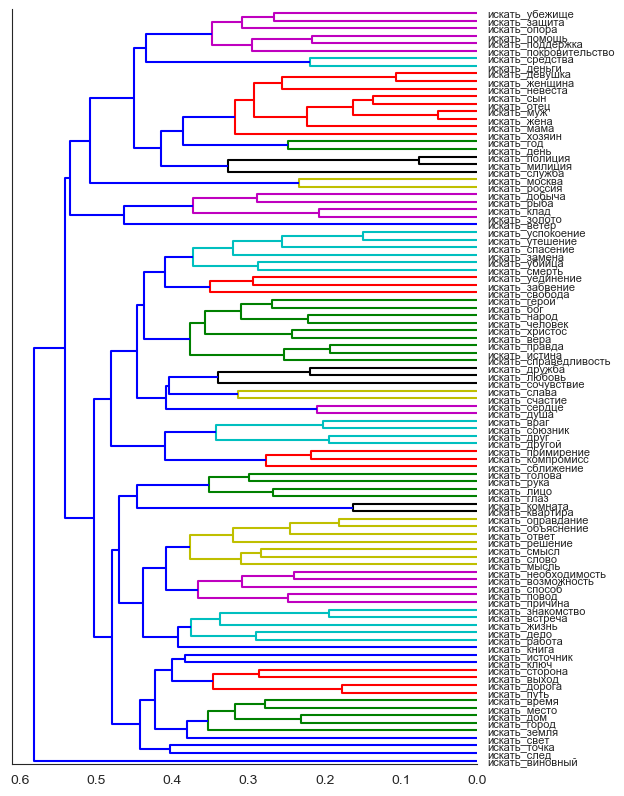

In [72]:
sns.set_style("white")

plt.figure(num=None, figsize=(6, 10), dpi=100)
dn = 

sns.despine()
plt.show()

А это график, позволяющий сравнить все три модели визуально (можно настраивать цвет с помощью `cmap = [magma|black_white|colours]`)

In [73]:
import random

In [74]:
df_plot = df.loc[:, ['bigram', 'kkcluster_n', 'kcluster_n', 'hcluster_n', ]]
df_plot = df_plot.rename(columns = {'kkcluster_n': 'NLTK Kmeans', 
                                    'kcluster_n': 'SciPy KMeans', 
                                    'hcluster_n': 'HierarClust'})
df_plot = df_plot.set_index('bigram')
del df_plot.index.name

df_plot.head()

,NLTK Kmeans,SciPy KMeans,HierarClust
искать_человек,18,7,17
искать_работа,6,3,4
искать_спасение,5,22,20
искать_место,11,3,2
искать_счастие,5,23,15


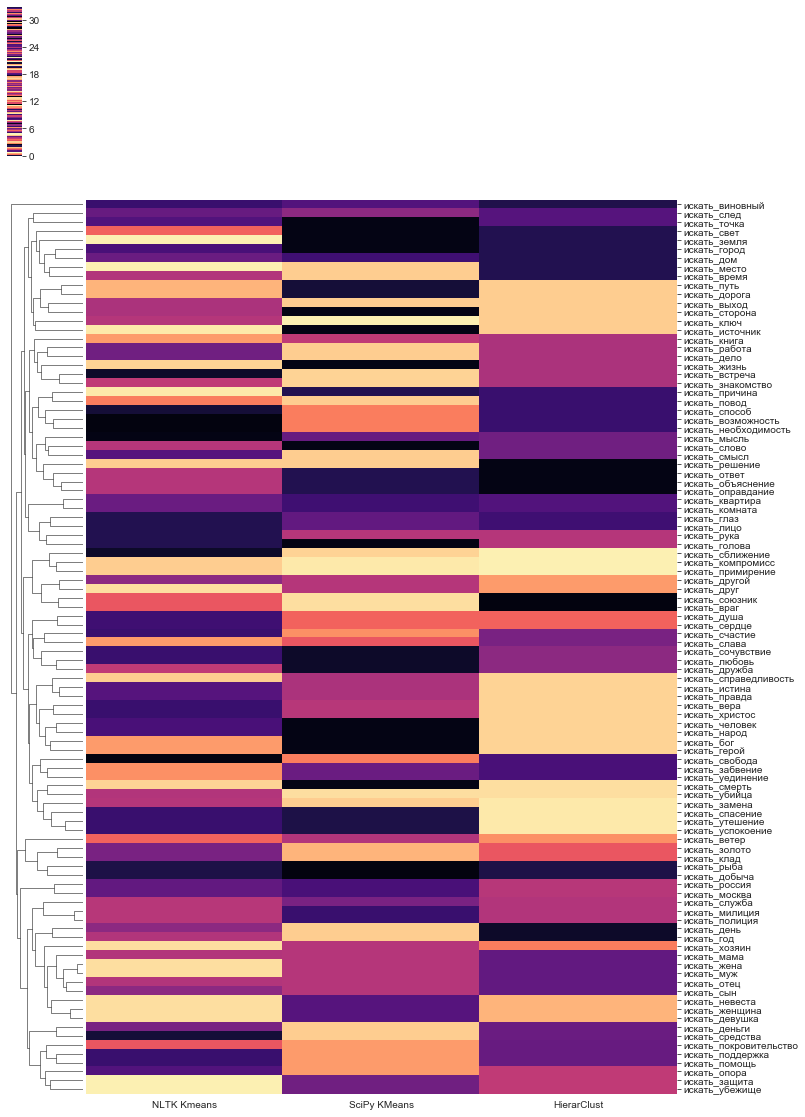

In [88]:
colours = sns.color_palette("Set3", 132)
for i in range(1, 3):
    random.shuffle(colours)

magma = sns.color_palette("magma", 132)
for i in range(1, 2):
    random.shuffle(magma)
    
black_white = sns.color_palette("Greys", 132)
for i in range(1, 4):
    random.shuffle(black_white)

g = sns.clustermap(df_plot, cmap = magma,
               yticklabels=True, figsize=(12, 20),
               col_cluster=False,
               row_linkage = Z)

#g.cax.set_visible(False)

plt.show()
g.savefig("magma1.png")

Хитмеп векторных представлений словосочетаний (просто для интереса)

In [76]:
df1 = pd.DataFrame(np.array(X, dtype='float64'), index=list(df['bigram']))
del df1.index.name

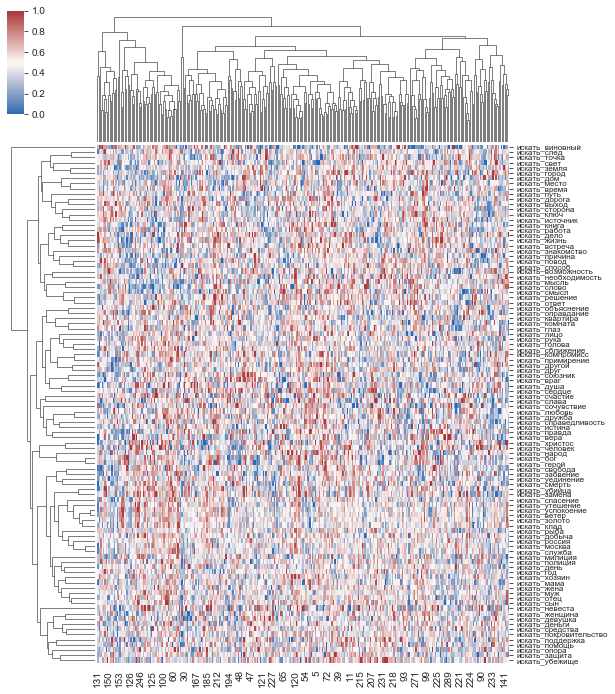

In [89]:
g2 = sns.clustermap(df1, metric="cosine", standard_scale=1, method="complete", cmap="vlag",
               yticklabels=True, figsize=(9, 12))
g2.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 8)
plt.show()
g2.savefig("heatmap.png")

## Дополнительно 3

тут я очень неоптимальным образом (потому что это первое что я придумала) смотрю на то, какие кластеры более "стабильны".

In [78]:
def get_bigram_cluster(bigram, method='h'):
    #bigram = 'искать_' + noun.lower()
    clstr = method + 'cluster_n'
    try:
        x = df.loc[df['bigram'] == bigram][clstr]
        combined = df[df[clstr] == int(x)].sort_values('compare')
        return combined.filter(regex='^[bvhk]', axis=1)
    except:
         print('такого слова нет, проверьте написание')

In [79]:
comp = pd.DataFrame()

for bigram in list(df['bigram']):
    
    ans = []
    
    h_kk = (get_bigram_cluster(bigram, method='h')['vector'].sum() == get_bigram_cluster(bigram, method='kk')['vector'].sum())
    if h_kk.all():
        ans.append(1)
    else:
        ans.append(0)
        
    h_k = (get_bigram_cluster(bigram, method='h')['vector'].sum() == get_bigram_cluster(bigram, method='k')['vector'].sum())
    if h_k.all():
        ans.append(1)
    else:
        ans.append(0)
        
    k_kk = (get_bigram_cluster(bigram, method='k')['vector'].sum() == get_bigram_cluster(bigram, method='kk')['vector'].sum())
    if k_kk.all():
        ans.append(1)
    else:
        ans.append(0)
        
    
    if sum(ans) == 3:
        ans.append(1)
    else:
        ans.append(0)
        
    a_row = pd.Series(ans)
    row_df = pd.DataFrame([a_row])
    comp = pd.concat([comp, row_df], ignore_index=True)

In [80]:
comp = comp.rename(columns = {0:'h_kk', 1:'h_k', 2:'k_kk', 3:'all_3'})
comp['b'] = list(df['bigram'])

**все три метода сходятся в кластеризации следующих сочетаний:**

In [81]:
n = 0
for i in list(comp.loc[comp['all_3'] == 1]['b']):
    n += 1
    _, noun = i.split('_')
    print(get_cluster_of_noun(noun))
    
print(n)

           bigram  hcluster_n  kcluster_n  kkcluster_n
58    искать_душа          14          14            9
67  искать_сердце          14          14            9
           bigram  hcluster_n  kcluster_n  kkcluster_n
62    искать_рыба          22          13           22
94  искать_добыча          22          13           22
           bigram  hcluster_n  kcluster_n  kkcluster_n
58    искать_душа          14          14            9
67  искать_сердце          14          14            9
           bigram  hcluster_n  kcluster_n  kkcluster_n
81  искать_россия          24          18           27
93  искать_москва          24          18           27
           bigram  hcluster_n  kcluster_n  kkcluster_n
81  искать_россия          24          18           27
93  искать_москва          24          18           27
           bigram  hcluster_n  kcluster_n  kkcluster_n
62    искать_рыба          22          13           22
94  искать_добыча          22          13           22
6


### помимо этих случаев

**KMean двух разных библиотек** сходятся в этих словосочетаниях

In [83]:
n = 0
for i in list(comp.loc[(comp['k_kk'] == 1) & 
                       (comp['all_3'] != 1)]['b']):
    n += 1
    print(i)
    
print(n)

искать_путь
искать_квартира
искать_дорога
искать_след
искать_комната
искать_мысль
искать_забвение
искать_дом
искать_уединение
9


**HC и KM из NLTK** сходятся в

In [84]:
n = 0
for i in list(comp.loc[(comp['h_kk'] == 1) & 
                       (comp['all_3'] != 1)]['b']):
    n += 1
    print(i)
    
print(n)

искать_милиция
искать_полиция
искать_служба
3


**HC и KM из SciPy** сходятся в

In [85]:
n = 0
for i in list(comp.loc[(comp['h_k'] == 1) & 
                       (comp['all_3'] != 1)]['b']):
    n += 1
    print(i)
    
print(n)

искать_женщина
искать_золото
искать_ветер
искать_глаз
искать_любовь
искать_сочувствие
искать_клад
искать_дружба
искать_невеста
искать_виновный
искать_девушка
искать_лицо
12


итого получается слудющая табличка (которую я приводила выше):


|  ╲ | HC  | KM1 | KM2 |
|---:|:---:|:---:|:---:|
|HC  |  ╲  |18   |9    |
|KM1 |18   |  ╲  |15   |
|KM2 |9    |15   |  ╲  |

Я проводила сравнение около 10 разных результатов и они остаются примерно такими же (±2). 

*Анна Полянская, 2020*